## **Import the TensorFlow library**

This code contains the training for a CNN in which the model learns to recognize the digits. This is different from the other training script because the model learns the digits from 0 to 6. The Idea is to have the digits 7,8,9 for the OL learning to eb applied on the OpenMV camera.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dropout, Dense, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt 
import numpy as np
import random
import os
import csv 
import tempfile

Load MNIST dataset and split in training and test

In [2]:
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

The original dataset shapes are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


In [3]:
label_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Split the train and test dataset in smaller datasets. Separation criterion is if the number is smaller than 6 or not.

In [4]:
train_samples = label_train.shape[0]
test_samples  = label_test.shape[0]

trainLow_samples  = np.sum(np.where(label_train < 6, 1, 0))
testLow_samples = np.sum(np.where(label_test <  6, 1, 0))

# separate in containers data that is lower nad higer than 6
data_low_train   = np.zeros([trainLow_samples,28,28])
label_low_train  = np.zeros(trainLow_samples)
data_high_train  = np.zeros([train_samples-trainLow_samples,28,28])
label_high_train = np.zeros(train_samples-trainLow_samples)

data_low_test   = np.zeros([testLow_samples,28,28])
label_low_test  = np.zeros(testLow_samples)
data_high_test  = np.zeros([test_samples-testLow_samples,28,28])
label_high_test = np.zeros(test_samples-testLow_samples)

j,k = 0,0
for i in range(0,train_samples):  
    if(label_train[i]<6):
        data_low_train[j,:,:] = data_train[i,:,:]
        label_low_train[j]    = label_train[i]
        j+=1
    else:
        data_high_train[k,:,:] = data_train[i,:,:]
        label_high_train[k]    = label_train[i]
        k+=1

j,k = 0,0
for i in range(0,test_samples):  
    if(label_test[i]<6):
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        j+=1
    else:
        data_high_test[k,:,:] = data_test[i,:,:]
        label_high_test[k]    = label_test[i]
        k+=1

print('After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:')
print(f'     Train dataset lower than 6 has shape:  {data_low_train.shape}')
print(f'     Train dataset higher than 6 has shape: {data_high_train.shape}')
print()
print(f'     Test dataset lower than 6 has shape:  {data_low_test.shape}')
print(f'     Test dataset higher than 6 has shape: {data_high_test.shape}')

After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:
     Train dataset lower than 6 has shape:  (36017, 28, 28)
     Train dataset higher than 6 has shape: (23983, 28, 28)

     Test dataset lower than 6 has shape:  (6031, 28, 28)
     Test dataset higher than 6 has shape: (3969, 28, 28)


2.0


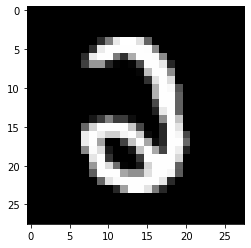

In [5]:
# Randomly check if dataset that I created are filled correctly
num = int(random.uniform(0,trainLow_samples))
plt.imshow(data_low_train[num], cmap="gray") # Import the image
print(label_low_train[num])
plt.show() # Plot the image

## **Pre process the data**

In [6]:
# Image dimensions
img_rows, img_cols = 28, 28

In [7]:
# Something I don't know
if K.image_data_format() == 'channels_first':
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], 1, img_rows, img_cols)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], 1, img_rows, img_cols)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], 1, img_rows, img_cols)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], 1, img_rows, img_cols)
    input_shape     = (1, img_rows, img_cols)
else:
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], img_rows, img_cols, 1)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], img_rows, img_cols, 1)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], img_rows, img_cols, 1)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], img_rows, img_cols, 1)
    input_shape     = (img_rows, img_cols, 1)

Normalize the dataset

In [8]:
data_low_train  = data_low_train.astype(np.float32) / 255.0
data_high_train = data_high_train.astype(np.float32) / 255.0
data_low_test   = data_low_test.astype(np.float32) / 255.0
data_high_test  = data_high_test.astype(np.float32) / 255.0

## **BUILD THE MODEL**

In [9]:
TRAIN_MODEL_1 = True
TRAIN_MODEL_2 = False

In [10]:
batch_size = 60
epochs     = 30
validation_split = 0.1
optimizer  = "adam"
loss       = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics    = ['accuracy']

In [11]:
if(False):
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(6, activation = "softmax"))

    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    model.summary()

In [12]:
if(TRAIN_MODEL_1):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(8,(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(6,activation='softmax'))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 8)         4616      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

In [13]:
# METHOD 2
# This model is a bit larger and should be much more precise in the feature extraction
if(TRAIN_MODEL_2):
    model2 = Sequential()
    model2.add(Conv2D(32, (3, 3), input_shape = input_shape))
    model2.add(Conv2D(32, (3, 3), activation = "relu"))
    model2.add(MaxPooling2D(pool_size = (2, 2)))
    model2.add(Dropout(0.2))
    model2.add(Flatten())
    model2.add(Dense(128, activation = "relu"))
    model2.add(Dropout(0.2))
    model2.add(Dense(6, activation = "softmax"))

    model2.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    model2.summary()

## TRAIN THE MODEL

In [14]:
if(TRAIN_MODEL_1):
    model.fit(data_low_train, label_low_train, epochs = epochs, batch_size = batch_size, validation_split = validation_split)

  # Evaluate the model performance
    test_loss, test_acc = model.evaluate(data_low_test, label_low_test)

  print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

Epoch 1/30
541/541 [==============================] - 17s 31ms/step - loss: 1.1533 - accuracy: 0.8990 - val_loss: 1.0610 - val_accuracy: 0.9831
Epoch 2/30
541/541 [==============================] - 17s 31ms/step - loss: 1.0698 - accuracy: 0.9752 - val_loss: 1.0558 - val_accuracy: 0.9881
Epoch 3/30
541/541 [==============================] - 17s 31ms/step - loss: 1.0637 - accuracy: 0.9805 - val_loss: 1.0532 - val_accuracy: 0.9908
Epoch 4/30
541/541 [==============================] - 17s 31ms/step - loss: 1.0597 - accuracy: 0.9842 - val_loss: 1.0526 - val_accuracy: 0.9914
Epoch 5/30
541/541 [==============================] - 17s 32ms/step - loss: 1.0593 - accuracy: 0.9850 - val_loss: 1.0529 - val_accuracy: 0.9914
Epoch 6/30
541/541 [==============================] - 17s 32ms/step - loss: 1.0576 - accuracy: 0.9865 - val_loss: 1.0526 - val_accuracy: 0.9911
Epoch 7/30
541/541 [==============================] - 17s 31ms/step - loss: 1.0558 - accuracy: 0.9880 - val_loss: 1.0538 - val_accuracy:

In [15]:
if(TRAIN_MODEL_2):

    labels_prova = keras.utils.to_categorical(label_low_train, 6)

    model2.fit(data_low_train, labels_prova, epochs = epochs, batch_size = batch_size, validation_split = validation_split )

    # Evaluate the model performance
    test_loss, test_acc = model2.evaluate(data_low_test, keras.utils.to_categorical(label_low_test, 6))

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

## TEST THE MODEL

In [16]:
if(TRAIN_MODEL_1):
    model_test = model
elif(TRAIN_MODEL_2):
    model_test = model2

In [17]:
predictions = model_test.predict(data_low_test)   # Make prediction of entire dataset

In [18]:
num = int(random.uniform(0,data_low_test.shape[0]))
print("Prediction = " , np.argmax(predictions[num]))
print("True label = " , label_low_test[num])

Prediction =  1
True label =  1.0


In [19]:
def plot_image(i, predictions_array, true_label, img):
    class_names = ['0','1','2','3','4','5']

    true_label, img = int(true_label[i]), img[i,:,:]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = (np.squeeze(img))## you have to delete the channel information (if grayscale) to plot the image
    plt.imshow(img, cmap="gray")

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)   


def plot_value_array(i, predictions_array, true_label):
    true_label = int(true_label[i])
    plt.grid(False)
    plt.xticks(range(6))
    plt.yticks([])
    thisplot = plt.bar(range(6), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

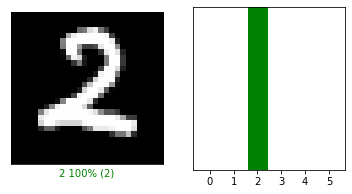

In [20]:
num = int(random.uniform(0, predictions.shape[0]))

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)

plot_image(num, predictions[num], label_low_test, data_low_test)
plt.subplot(1,2,2)

plot_value_array(num, predictions[num], label_low_test)
plt.show()

## **SAVE ORIGINAL MODEL AND FROZEN MODEL**

In [21]:
def save_summary_model(model, MODEL_PATH, flag):
    new_file = open(MODEL_PATH + 'model_summary.txt', "w")

    new_file.write("PARAMETERS SAVED FROM THE TRAINING")
    if(flag==0):
        new_file.write("\n\n This model has been trained for learning the first 6 digits from the MNIST dataset, this is the ORIGINAL MODEL")
    elif(flag==1):
        new_file.write("\n\n This model has been trained for learning the first 6 digits from the MNIST dataset, this is the FROZEN MODEL")
    new_file.write("\n")
    new_file.write("\n Batch size:       " + str(batch_size))
    new_file.write("\n Epochs:           " + str(epochs))
    new_file.write("\n Metrics:          " + str(metrics))
    new_file.write("\n Optimizer:        " + optimizer)
    new_file.write("\n Loss:             " + "SparseCategoricalCrossentropy \n\n")

    model.summary(print_fn=lambda x: new_file.write(x + '\n'))

In [22]:
ROOT_PATH = os.path.abspath('')
SAVE_MODEL_PATH = ROOT_PATH + "\\Backup_models\\Last_trained_model"

ORIGINAL_MODEL_PATH = SAVE_MODEL_PATH + "\\Original_model\\" 

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Save ORIGINAL MODEL as mnist_cnn.h5')
model.save(ORIGINAL_MODEL_PATH + "mnist_cnn.h5")
save_summary_model(model_test, ORIGINAL_MODEL_PATH, 0)

Test loss: 1.0477176904678345
Test accuracy: 0.9960205554962158
Save ORIGINAL MODEL as mnist_cnn.h5


Now create the frozen model version for the one just saved. Which means just to cut away the last layer and save the model without the kast kayer. This should be instead saved in a txt/library file.

### SAVE THE FROZEN MODEL

In [23]:
# CREATE AND SAVE THE FROZEN MODEL
frozen_model = keras.models.Sequential(model_test.layers[:-1])
frozen_model.summary()
frozen_model.compile()

FROZEN_MODEL_PATH = SAVE_MODEL_PATH + "\\Frozen_model\\"

print('Save FROZEN MODEL model as mnist_cnn.h5')
frozen_model.save(FROZEN_MODEL_PATH + "mnist_cnn.h5")
save_summary_model(frozen_model, FROZEN_MODEL_PATH, 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 8)         4616      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 128)              

Now save also the last layer weights in a txt file, this will later be used in the OpenMV camera for loading the weights that have been already trained. (ll = last layer)

In [24]:
ll_weights = np.array(model_test.layers[-1].get_weights()[0])   # get last layer weights from TF model
ll_biases  = np.array(model_test.layers[-1].get_weights()[1])   # get last layer biases from TF model
print(f'The shape of the last layer weights is: {ll_weights.shape}')
print(f'The shape of the last layer biases is: {ll_biases.shape}')


# -------- WEIGHTS
# NB: the filof weights is separated in smaller rows (338 float values on each row)
# thjis is done in order to make it easier for the OpenMV camera to load each line (memory problems)
with open(FROZEN_MODEL_PATH + 'll_weights.txt', 'w') as new_file:

    for j in range(0, ll_weights.shape[1]):
        for i in range(0, ll_weights.shape[0]): 
            if(i%338==0 and i!= 0 and i != ll_weights.shape[0]-1):
                new_file.write('\n')
                
            new_file.write(str(ll_weights[i,j]))
            
            if(i == ll_weights.shape[0]-1):
                new_file.write('\n')
            elif((i+1)%338 == 0):
                dummy = 0
            else:
                new_file.write(',')

new_file.close()


# -------- BIASES
with open(FROZEN_MODEL_PATH + 'll_biases.txt', 'w') as new_file:

    for i in range(0, ll_biases.shape[0]):     
        new_file.write(str(ll_biases[i])) 
        if(i!=ll_biases.shape[0]-1):
            new_file.write(',')
new_file.close()

The shape of the last layer weights is: (128, 6)
The shape of the last layer biases is: (6,)


## PRUNING

https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras

In [25]:
# Install needed optimization toolkit
from tensorflow.keras.models import load_model
import tensorflow_model_optimization as tfmot

In [26]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after n epochs.
batch_size = 32
epochs = 20
validation_split = 0.1  # 10% of training set will be used for validation set. 

num_images = data_low_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}


model_for_pruning = prune_low_magnitude(model_test, **pruning_params)

# `prune_low_magnitude` requires a recompile.

# Select appropriate optimizer
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

model_for_pruning.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 26, 26, 64)        1218      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 13, 13, 64)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 11, 11, 8)         9226      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 5, 5, 8)           1         
_________________________________________________________________
prune_low_magnitude_dropout  (None, 5, 5, 8)           1         
_________________________________________________________________
prune_low_magnitude_flatten  (None, 200)               1         
_________________________________________________

In [27]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(data_low_train, label_low_train,
                    batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=callbacks)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

1013/1013 [==============================] - 18s 18ms/step - loss: 1.0491 - accuracy: 0.9948 - val_loss: 1.0492 - val_accuracy: 0.9942
Epoch 3/20
1013/1013 [==============================] - 18s 18ms/step - loss: 1.0492 - accuracy: 0.9946 - val_loss: 1.0494 - val_accuracy: 0.9947
Epoch 4/20
1013/1013 [==============================] - 19s 18ms/step - loss: 1.0492 - accuracy: 0.9945 - val_loss: 1.0490 - val_accuracy: 0.9944
Epoch 5/20
1013/1013 [==============================] - 21s 21ms/step - loss: 1.0483 - accuracy: 0.9956 - val_loss: 1.0488 - val_accuracy: 0.9947
Epoch 6/20
1013/1013 [==============================] - 30s 29ms/step - loss: 1.0489 - accuracy: 0.9949 - val_loss: 1.0488 - val_accuracy: 0.9947
Epoch 7/20
1013/1013 [==============================] - 23s 23ms/step - loss: 1.0491 - accuracy: 0.9949 - val_loss: 1.0492 - val_accuracy: 0.9944
Epoch 8/20
1013/1013 [==============================] - 22s 22ms/step - loss: 1.0486 - accuracy: 0.9954 - val_loss: 1.0488 - val_accura

In [28]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(data_low_test, label_low_test, verbose=0)

print('Original test accuracy: ', test_acc)
print('Pruned test accuracy:   ', model_for_pruning_accuracy)

Original test accuracy:  0.9960205554962158
Pruned test accuracy:    0.9975128769874573


## CREATE A x3 SMALLER MODEL FROM PRUNING

In [29]:
# First, create a compressible model for TensorFlow

PRUNED_MODEL_PATH = SAVE_MODEL_PATH + "\\Pruned_model\\"


model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.save(PRUNED_MODEL_PATH + 'pruned.h5', include_optimizer=False)

In [30]:
# Then, create a compressible model for TFLite

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

with open(PRUNED_MODEL_PATH + 'Pruned.tflite', 'wb') as f:
    f.write(pruned_tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\massi\AppData\Local\Temp\tmpyycv98t7\assets


In [31]:
def get_gzipped_model_size(file):
    # Returns size of gzipped model, in bytes.
    import os
    import zipfile

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    return os.path.getsize(zipped_file)

In [32]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(FROZEN_MODEL_PATH + "mnist_cnn.h5")))
print("Size of gzipped pruned Keras model  : %.2f bytes" % (get_gzipped_model_size(PRUNED_MODEL_PATH + 'pruned.h5')))
print("Size of gzipped pruned TFlite model : %.2f bytes" % (get_gzipped_model_size(PRUNED_MODEL_PATH + 'Pruned.tflite')))

Size of gzipped baseline Keras model: 118008.00 bytes
Size of gzipped pruned Keras model  : 41078.00 bytes
Size of gzipped pruned TFlite model : 39284.00 bytes


## CREATE A 10x SMALLER MODEL, COMBINE PRUNING WITH QUANTIZATION

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
    f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model             : %.2f bytes" % (get_gzipped_model_size(FROZEN_MODEL_PATH + "mnist_cnn.h5")))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

INFO:tensorflow:Assets written to: C:\Users\massi\AppData\Local\Temp\tmp5i6hs9b0\assets


INFO:tensorflow:Assets written to: C:\Users\massi\AppData\Local\Temp\tmp5i6hs9b0\assets


Saved quantized and pruned TFLite model to: C:\Users\massi\AppData\Local\Temp\tmp6118ss73.tflite
Size of gzipped baseline Keras model             : 118008.00 bytes
Size of gzipped pruned and quantized TFlite model: 14485.00 bytes


## SAVE THE FROZEN MODEL VERSION OF THE PRUNED MODEL

In [34]:
frozen_pruned_model = keras.models.Sequential(model_for_export.layers[:-1])
frozen_pruned_model.summary()
frozen_pruned_model.compile()

FROZEN_PRUNED_MODEL_PATH = SAVE_MODEL_PATH + "\\Frozen_Pruned_model\\"

print('Save FROZEN PRUNED MODEL model as mnist_cnn.h5')
frozen_model.save(FROZEN_PRUNED_MODEL_PATH + "mnist_cnn.h5")
save_summary_model(model_for_export, FROZEN_PRUNED_MODEL_PATH, 1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 8)         4616      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 128)              

In [35]:
ll_weights = np.array(model_for_export.layers[-1].get_weights()[0])   # get last layer weights from TF model
ll_biases  = np.array(model_for_export.layers[-1].get_weights()[1])   # get last layer biases from TF model
print(f'The shape of the last layer weights is: {ll_weights.shape}')
print(f'The shape of the last layer biases is: {ll_biases.shape}')


# -------- WEIGHTS
# NB: the filof weights is separated in smaller rows (338 float values on each row)
# thjis is done in order to make it easier for the OpenMV camera to load each line (memory problems)
with open(FROZEN_PRUNED_MODEL_PATH + 'll_weights.txt', 'w') as new_file:

    for j in range(0, ll_weights.shape[1]):
        for i in range(0, ll_weights.shape[0]): 
            if(i%338==0 and i!= 0 and i != ll_weights.shape[0]-1):
                new_file.write('\n')
                
            new_file.write(str(ll_weights[i,j]))
            
            if(i == ll_weights.shape[0]-1):
                new_file.write('\n')
            elif((i+1)%338 == 0):
                dummy = 0
            else:
                new_file.write(',')

new_file.close()


# -------- BIASES
with open(FROZEN_PRUNED_MODEL_PATH + 'll_biases.txt', 'w') as new_file:

    for i in range(0, ll_biases.shape[0]):     
        new_file.write(str(ll_biases[i])) 
        if(i!=ll_biases.shape[0]-1):
            new_file.write(',')
new_file.close()

The shape of the last layer weights is: (128, 6)
The shape of the last layer biases is: (6,)


## DOWNLOAD ENTIIRE MODEL DIRECTORY

In [36]:
#%cd '/content'
#from google.colab import files
#import shutil
#shutil.make_archive('Colab_models', 'zip', 'Models')
#files.download('Colab_models.zip') 